# CfD Auction Crowd Elicitation

<br>

### Imports

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Stats
from sklearn.neighbors.kde import KernelDensity

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)
        
rgb_2_mpl = lambda rgb_tuple: tuple(rgb_val/250 for rgb_val in rgb_tuple)

aurora_colours = {
    'red' : rgb_2_mpl((140, 7, 0)),
    'yellow' : rgb_2_mpl((242, 203, 76)),
    'gold' : rgb_2_mpl((245, 158, 0)),
    'silver' : rgb_2_mpl((150, 150, 150)),
    'blue' : rgb_2_mpl((0, 0, 225))
}

<br>

### Reading in Data

In [3]:
df_predictions = pd.read_csv('data/auction_guesses.csv')
df_predictions.head()

price   source  person  organisation
0   49.0  twitter     NaN           NaN
1   52.5  twitter     NaN           NaN
2   43.1  twitter     NaN           NaN
3   50.0  twitter     NaN           NaN
4   40.0  twitter     NaN           NaN

<br>

### Filtering Predictions

Here we remove predictions which are extreme outliers

In [4]:
def filter_preds(df_predictions, source='all'):
    if source != 'all':
        df_predictions = df_predictions[df_predictions['source']==source]
        
    filtered_predictions = (df_predictions
                            .sort_values('price')
                            .loc[df_predictions['price']>10, 'price']
                            .values
                            .reshape(-1, 1)
                           )
    
    return filtered_predictions

filtered_predictions = filter_preds(df_predictions)
filtered_predictions.T[0]

array([36.99, 37.  , 40.  , 40.  , 42.9 , 43.  , 43.  , 43.1 , 44.4 ,
       45.  , 45.  , 46.  , 46.5 , 47.5 , 47.95, 48.5 , 49.  , 49.5 ,
       50.  , 50.42, 50.5 , 51.  , 52.5 , 53.  , 55.5 ])

<br>

We can then visualise the filtered price prediction distributions

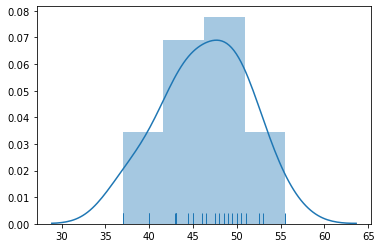

In [5]:
sns.distplot(filtered_predictions.T[0], rug=True)

<br>

### Determining Optimum KDE Bandwidth

Seaborn takes a number of shortcuts when fitting the KDE for the distribution plots. To get around this we'll fit the KDE ourselves and use k-fold cross validation when determining the likelihood of seeing a single price prediction for the given distribution, with k set to the total number of predictions.

(-82, -75)

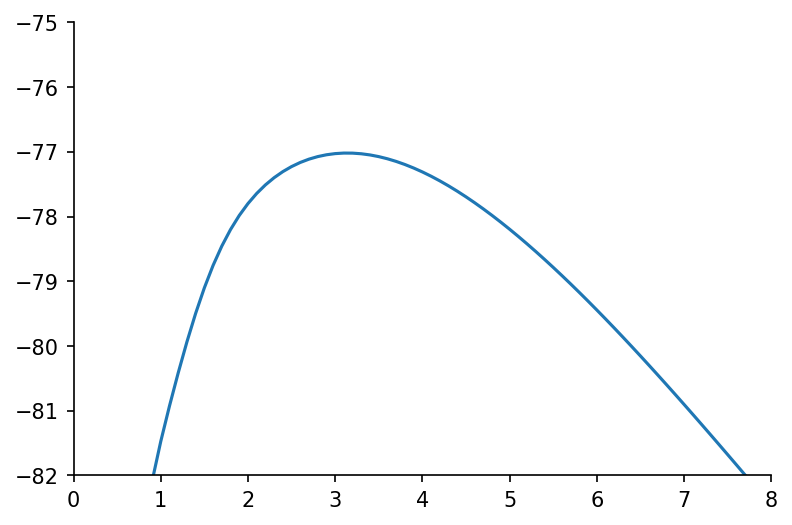

In [22]:
def KDE_bw_2_MLE(filtered_predictions, bw):
    MLE_score = 0
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)

    for elem_idx in range(filtered_predictions.shape[0]):
        filtered_predictions_train = filtered_predictions.copy()
        filtered_predictions_train = np.delete(filtered_predictions_train, elem_idx)

        filtered_predictions_test = np.array(filtered_predictions[elem_idx])

        ## fitting & scoring
        kde = kde.fit(filtered_predictions_train.reshape(-1, 1))
        MLE_score += kde.score(filtered_predictions_test.reshape(-1, 1))

    return MLE_score

def find_bw_MLEs(filtered_predictions, bw_start=0.1, bw_end=10, bw_steps=100):
    s_bws = pd.Series(np.linspace(bw_start, bw_end, bw_steps))

    s_MLE_scores = s_bws.apply(lambda bw: KDE_bw_2_MLE(filtered_predictions, bw))
    s_MLE_scores.index = s_bws
    
    return s_MLE_scores

s_MLE_scores = find_bw_MLEs(filtered_predictions)

## Plotting
fig, ax = plt.subplots(dpi=150)

s_MLE_scores.plot(ax=ax)

hide_spines(ax)
ax.set_xlim(0, 8)
ax.set_ylim(-82, -75)

<br>

Having calculated the likelihood of seeing the predictions for different bandwidths we can take the most likely one

In [15]:
optimum_bw = s_MLE_scores.idxmax()
round(optimum_bw, 1)

3.1

<br>

### Determining the Price Prediction Density Distribution

We'll now use the optimal bandwidth to fit the KDE and then calculate the likelihood for a range of price prediction values

In [8]:
def fit_KDE(filtered_predictions, optimum_bw=2):
    kde = KernelDensity(kernel='gaussian', bandwidth=optimum_bw)
    kde = kde.fit(filtered_predictions)
    return kde

kde = fit_KDE(filtered_predictions, optimum_bw)

s_prices = pd.Series(np.linspace(30, 65, 651))

s_sample_likelihoods = pd.Series(kde.score_samples(s_prices.values.reshape(-1, 1)))
s_sample_likelihoods.index = s_prices

s_sample_likelihoods.head()

30.000000   -7.050190
30.053846   -7.009905
30.107692   -6.969900
30.161538   -6.930174
30.215385   -6.890727
dtype: float64

<br>

From the range of price prediction likelihoods we can take the most likely value

In [9]:
def calc_probability_densities(kde, pred_min=30, pred_max=65, pred_steps=36):
    vals = np.linspace(pred_min, pred_max, pred_steps).reshape(-1, 1)
    
    logprobs = kde.score_samples(vals)
    probs = np.exp(logprobs)
    
    s_sample_likelihoods = pd.Series(probs, index=vals.T[0])
    return s_sample_likelihoods

s_sample_probs = calc_probability_densities(kde)
most_likely_price = s_sample_probs.idxmax()

round(most_likely_price, 2)

47.0

<br>

And also visualise the full distribution

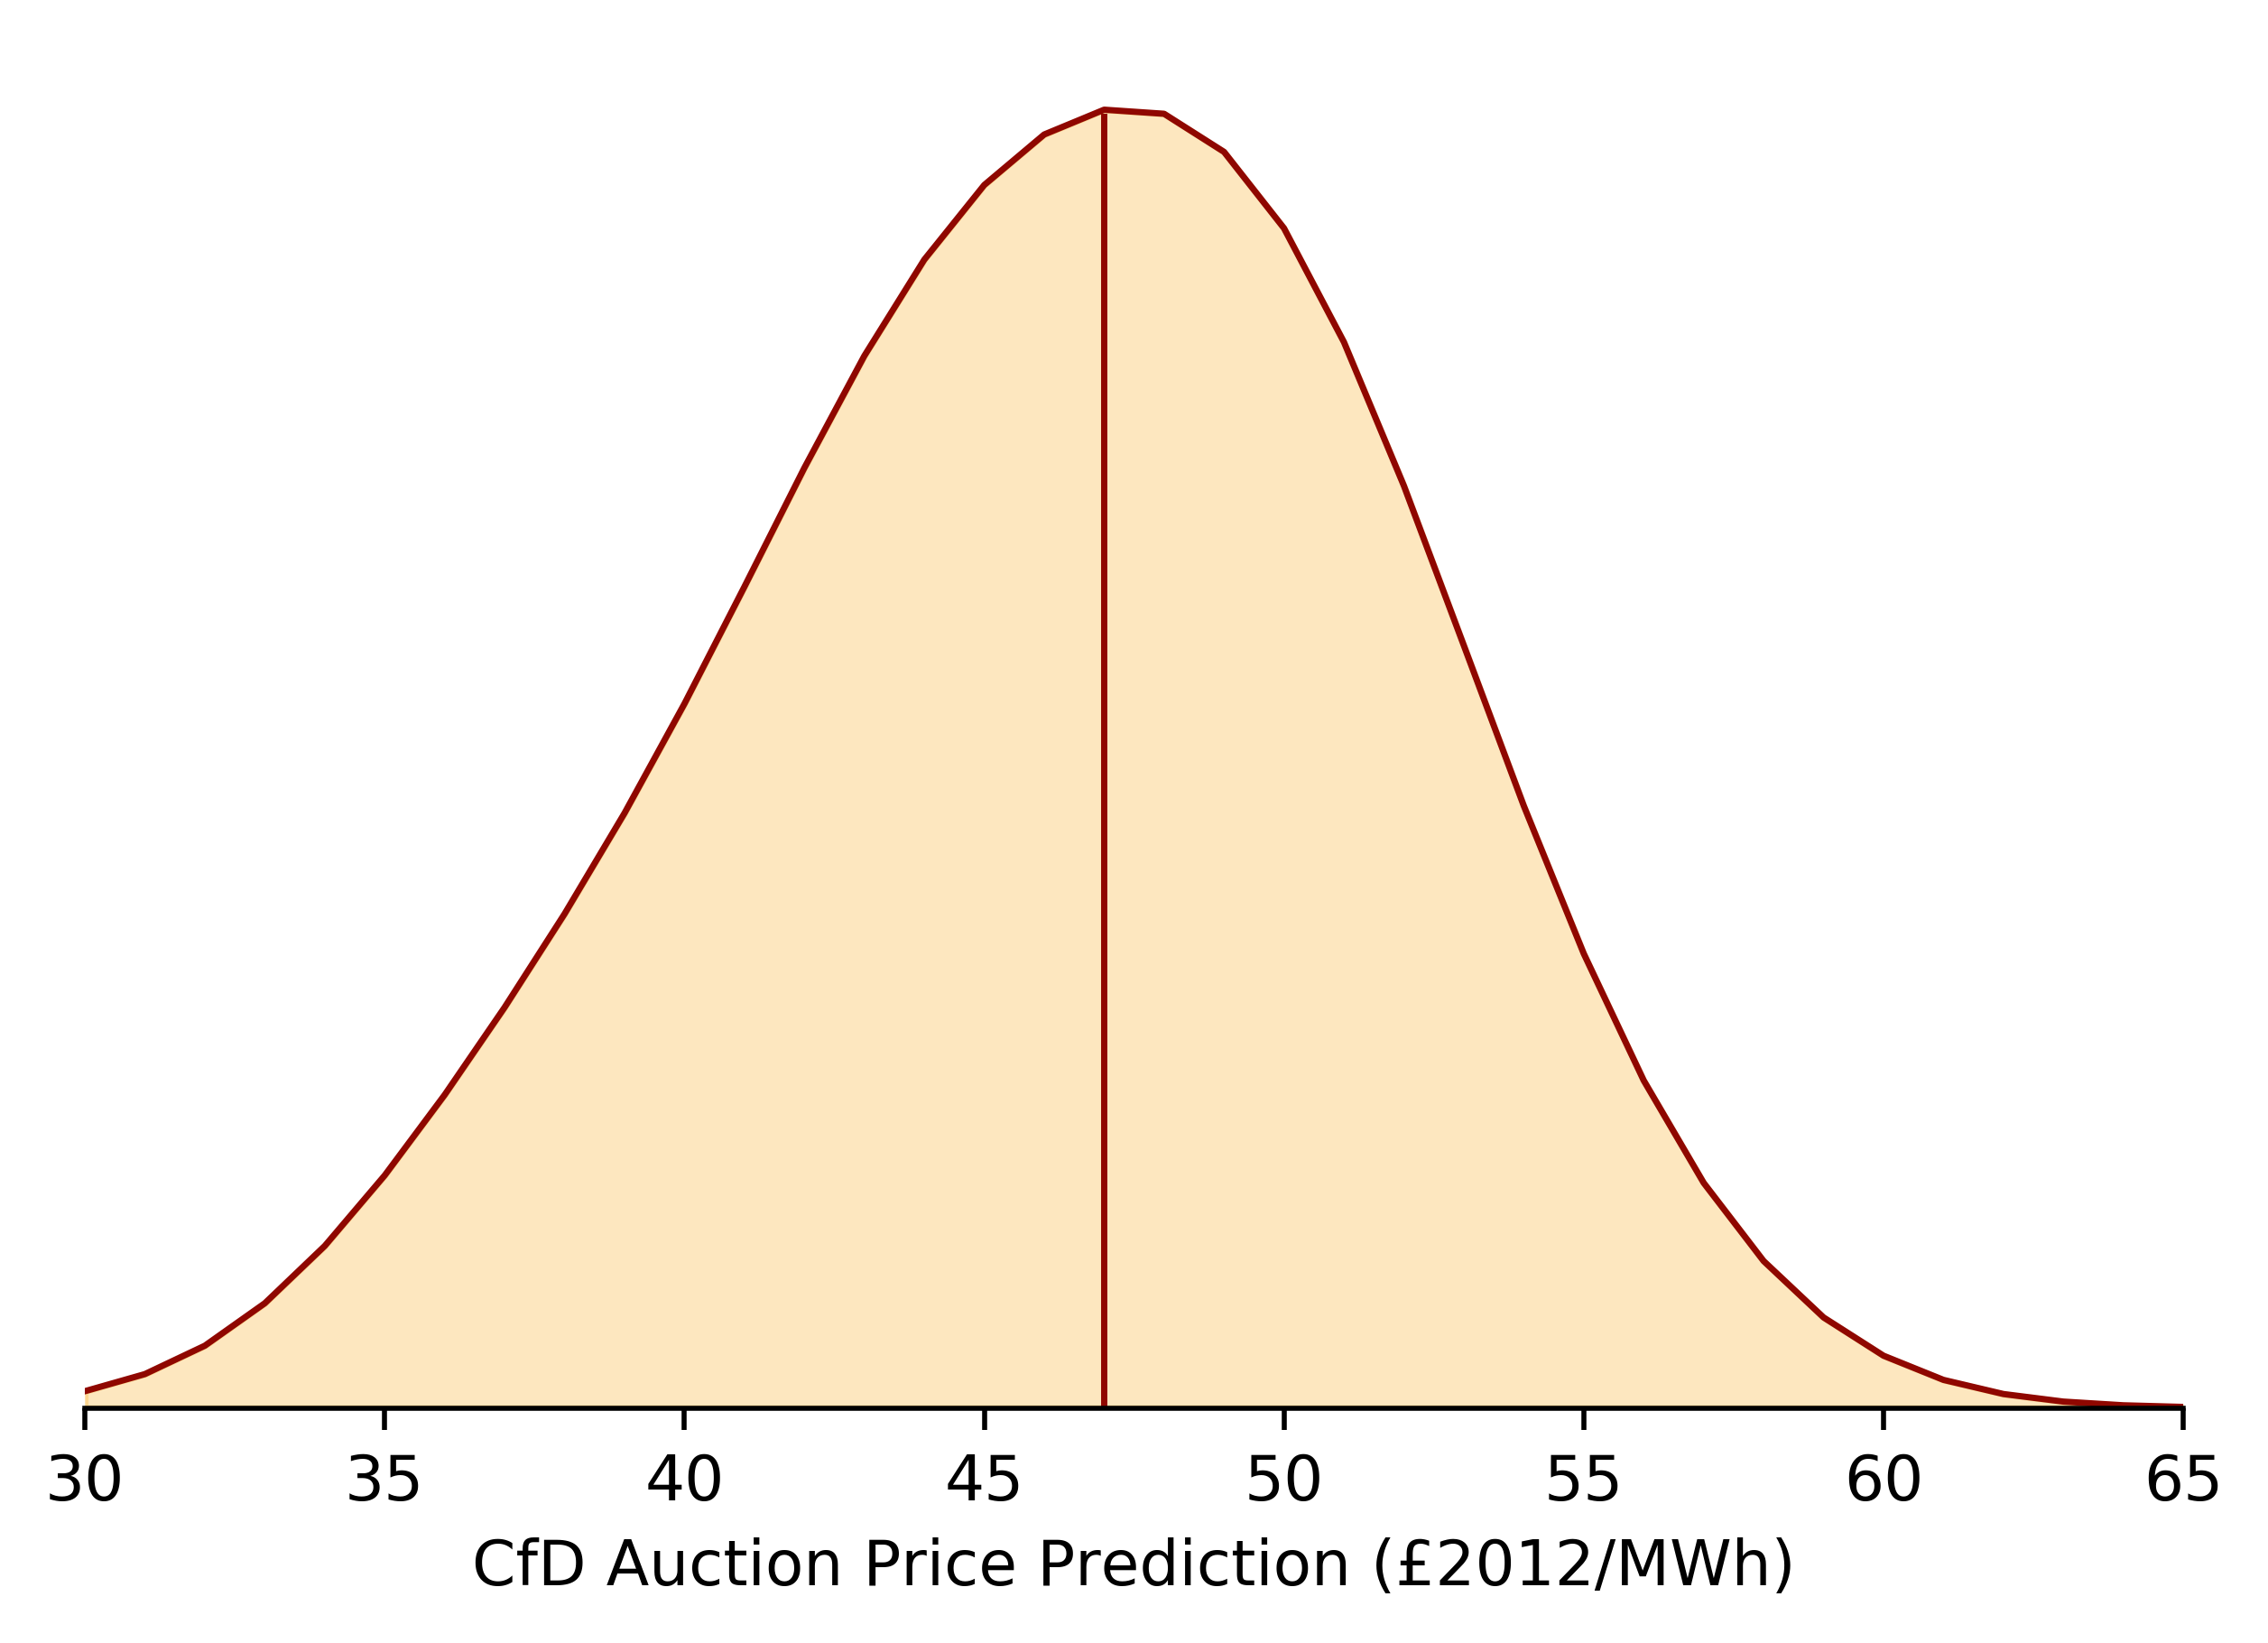

In [11]:
def plot_dist(s_sample_probs, l_color=aurora_colours['red'], f_color=aurora_colours['gold'], ax=None, return_ax=False):
    probs = s_sample_probs.values
    values = s_sample_probs.index.values.T
    most_likely_price = s_sample_probs.idxmax()
    
    ## Plotting
    if ax == None:
        fig, ax = plt.subplots(dpi=500)

    ax.plot(values, probs, lw=1, color=l_color)
    ax.fill_between(values, probs, alpha=0.25, color=f_color)
    ax.plot([most_likely_price, most_likely_price], [0, probs.max()*0.995], lw=1, color=l_color)

    ax.set_ylim(0)
    ax.set_xlim(values.min(), values.max())
    ax.set_yticks([], [])
    hide_spines(ax, positions=['top', 'left', 'right'])
    ax.set_xlabel('CfD Auction Price Prediction (Â£2012/MWh)')
    
    fig.savefig('img/CfD_price_elicitiation.')
    
    if return_ax == True:
        return ax
    
plot_dist(s_sample_probs)

<br>

### Creating Wrapper Function

We'll also wrap everything we've done into a single function

In [12]:
def prediction_2_probabilities(df_predictions, source='all'):
    filtered_predictions = filter_preds(df_predictions, source=source)

    s_MLE_scores = find_bw_MLEs(filtered_predictions)
    optimum_bw = s_MLE_scores.idxmax()

    kde = fit_KDE(filtered_predictions, optimum_bw)
    s_sample_probs = calc_probability_densities(kde)
    most_likely_price = s_sample_probs.idxmax()

    print(f'Optimum KDE bandwidth: {round(optimum_bw, 2)}')
    print(f'Most likely price: {round(most_likely_price, 2)}')
    
    return s_sample_probs

s_sample_probs = prediction_2_probabilities(df_predictions, source='twitter')
s_sample_probs.head()

Optimum KDE bandwidth: 3.1
Most likely price: 47.0


30.0    0.000867
31.0    0.001751
32.0    0.003221
33.0    0.005418
34.0    0.008385
dtype: float64